In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

# Import and Preprocess 

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Revised import function

We pause to look at the revised form of our text import function. The parsing function has been replaced with NLTK, which has improved the results of POS tagging. However, this has required some added string manipulation to produce better tokens.

In [3]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [4]:
"""
NOTE: NLTK tokenization messes up whitespace and 
handles non-alpha characters differently.
"""

def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [5]:
src_file_name = '2701-0.txt'
src_file_url = 'https://www.gutenberg.org/files/2701/2701-0.txt'

import os

if not os.path.exists(src_file_name):
  import requests
  with open(src_file_name, 'w', encoding='utf-8') as src_file_on_disk:
    src_file_url = src_file_url
    src_file_text = requests.get(src_file_url).text
    src_file_on_disk.write(src_file_text)

cfg = dict(
    src_file = src_file_name,
    body_start = 341,
    body_end = 21964,
    chap_pat = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
)

K, V = text_to_tokens(**cfg)

In [6]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
# nouns = (K.punc == 0) & K.pos.str.match(r'^N')
# verbs = (K.punc == 0) & K.pos.str.match(r'^V')
# K.loc[nouns, 'lemma'] = K[nouns].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='n'), 1)
# K.loc[verbs, 'lemma'] = K[verbs].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='v'), 1)

In [7]:
K.head()

pos  token_str  punc  num   term_str  \
chap_num para_num sent_num token_num                                         
0        0        0        0          NNP  ETYMOLOGY     0    0  etymology   
                           1            .          .     1    0        NaN   
         1        0        0            (          (     1    0        NaN   
                           1          VBN   Supplied     0    0   supplied   
                           2           IN         by     0    0         by   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             5005  
                           1               -1  
         1        0        0               -1  
                           1            14441  
                           2             1987

In [8]:
V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,4724,0.021629,a,1
1,aback,2,0.000009,aback,0
2,abaft,2,0.000009,abaft,0
3,abandon,3,0.000014,abandon,0
4,abandoned,7,0.000032,abandon,0


## Test to see if 'and' is annotated properly

In [9]:
K[K.term_str=='and'].pos

chap_num  para_num  sent_num  token_num
0         2         0         12           CC
                    1         7            CC
          3         0         10           CC
          4         1         4            CC
          5         2         0            CC
          8         0         9            CC
                              30           CC
                    3         43           CC
                              51           CC
          9         1         18           CC
                              40           CC
                              48           CC
                              54           CC
                              63           CC
                              67           CC
                    3         8            CC
                    4         5            CC
                              33           CC
                              44           CC
          11        0         1            CC
          15        0         11        

In [10]:
K[(K.term_str=='and') & K.pos.isna()]

,,,,pos,token_str,punc,num,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,,,


## Discussion

* Why does NLTK's parser produce better results? 
* What does this imply about the POS algorithm? 

# Create DTM

*   Which bag? Chapters? Paragraphs?
*   Which item? tokens? terms? stems?
*   Let's try chapters and terms



## Create word mask

Let's filter out stopwords -- another hyperparameter. 

In [11]:
WORDS = (K.punc == 0) & (K.num == 0) & K.term_id.isin(V[V.stop==0].index)

## Extrct BOW from tokens

To extract a bag-of-words model from our tokens table, we apply a simple `groupby()` operation. Note that we can drop in our hyperparameters easily -- CHAPS and 'term_id' and be replaced. We can easily write a function to simplify this process and make it more configurable. 


In [14]:
BOW = K[WORDS].groupby(CHAPS+['term_id'])['term_id'].count() # number of occurrences of word per chapter

In [18]:
BOW.head(10) # narrow/sparse representation, every chapter has only the term ids it contains

chap_num  term_id
0         33         1
          69         1
          70         1
          99         2
          129        1
          138        1
          148        5
          154        1
          157        1
          219        1
Name: term_id, dtype: int64

## Convert BOW to DTM

In [19]:
DTM = BOW.unstack().fillna(0) # every chapter has every term listed, possibility space (wide representation)

In [20]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Discussion

* What is added in the process of converting our BOW data frame into a matrix?
* How would you characterize the difference between the BOW and the DTM data frames?



# Compute Term Frequencies and Weights

## Compute TF

In [22]:
alpha = .000001 # We introduce an arbitrary smoothing value, prevents divide-by-0 later on
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [23]:
TF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,...,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017519e-10,5.017524e-04,5.017524e-04
1,9.336920e-10,9.336920e-10,9.336930e-04,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,...,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10,9.336920e-10
2,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,...,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09,1.390788e-09
3,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,...,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10,3.533548e-10
4,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,...,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09,1.264195e-09


In [25]:
TF.sum(1) # check to see each row sums to 1 since probabilities should add up to 1. 
# Note: sum(1) --> add rows (axis 1), not columns (axis 0), defaults to column addition

chap_num
0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
5      1.000000
6      1.000000
7      1.000000
8      1.000000
9      1.000000
10     1.000000
11     1.000000
12     1.000000
13     1.000000
14     1.000000
15     1.000000
16     1.000000
17     1.000000
18     1.000000
19     1.000000
20     1.000000
21     1.000000
22     1.000000
23     0.999999
24     1.000000
25     0.999999
26     1.000000
27     1.000000
28     1.000000
29     1.000000
         ...   
107    1.000000
108    1.000000
109    1.000000
110    1.000000
111    0.999999
112    1.000000
113    1.000000
114    1.000000
115    1.000000
116    1.000000
117    0.999999
118    1.000000
119    1.000000
120    0.999999
121    1.000000
122    0.999996
123    1.000000
124    1.000000
125    1.000000
126    1.000000
127    1.000000
128    1.000000
129    1.000000
130    1.000000
131    0.999999
132    1.000000
133    1.000000
134    1.000000
135    1.000000
136    0.999999
Length: 137, dt

## Compute TFIDF

In [26]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V[V.stop==0]['df'])

In [27]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,3.059699e-09,3.059699e-09,2.766193e-09,2.396419e-09,3.561451e-09,3.059699e-09,3.059699e-09,3.561451e-09,3.059699e-09,3.561451e-09,...,3.561451e-09,2.557947e-09,3.059699e-09,2.766193e-09,3.561451e-09,3.561451e-09,3.561451e-09,3.561451e-09,3.561455e-03,3.561455e-03
1,5.693684e-09,5.693684e-09,5.147514e-03,4.459410e-09,6.627376e-09,5.693684e-09,5.693684e-09,6.627376e-09,5.693684e-09,6.627376e-09,...,6.627376e-09,4.759992e-09,5.693684e-09,5.147509e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09,6.627376e-09
2,8.481069e-09,8.481069e-09,7.667510e-09,6.642547e-09,9.871856e-09,8.481069e-09,8.481069e-09,9.871856e-09,8.481069e-09,9.871856e-09,...,9.871856e-09,7.090281e-09,8.481069e-09,7.667510e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09,9.871856e-09
3,2.154769e-09,2.154769e-09,1.948069e-09,1.687659e-09,2.508124e-09,2.154769e-09,2.154769e-09,2.508124e-09,2.154769e-09,2.508124e-09,...,2.508124e-09,1.801414e-09,2.154769e-09,1.948069e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09,2.508124e-09
4,7.709104e-09,7.709104e-09,6.969597e-09,6.037929e-09,8.973300e-09,7.709104e-09,7.709104e-09,8.973300e-09,7.709104e-09,8.973300e-09,...,8.973300e-09,6.444909e-09,7.709104e-09,6.969597e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09,8.973300e-09


## Compute TFTH (Experiment)

In [29]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1) # term frequency, term entropy

In [30]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.211241e-11,5.621709e-12,2.023569e-11,3.792221e-11,6.519129e-12,8.523135e-12,1.646764e-11,7.500809e-12,1.361376e-11,2.292857e-12,...,9.154935e-12,3.659806e-11,6.467647e-12,3.043225e-11,3.892685e-12,4.510988e-12,5.806689e-12,6.429971e-12,2.763670e-06,2.763670e-06
1,2.253955e-11,1.046124e-11,3.765591e-05,7.056807e-11,1.213121e-11,1.586040e-11,3.064405e-11,1.395799e-11,2.533336e-11,4.266695e-12,...,1.703609e-11,6.810401e-11,1.203541e-11,5.663027e-11,7.243758e-12,8.394336e-12,1.080546e-11,1.196530e-11,5.142810e-12,5.142810e-12
2,3.357395e-11,1.558261e-11,5.609058e-11,1.051152e-10,1.807014e-11,2.362497e-11,4.564606e-11,2.079122e-11,3.773549e-11,6.355486e-12,...,2.537623e-11,1.014448e-10,1.792744e-11,8.435403e-11,1.078999e-11,1.250384e-11,1.609535e-11,1.782300e-11,7.660510e-12,7.660510e-12
3,8.530067e-12,3.959044e-12,1.425083e-11,2.670641e-11,4.591045e-12,6.002350e-12,1.159721e-11,5.282385e-12,9.587382e-12,1.614726e-12,...,6.447290e-12,2.577389e-11,4.554789e-12,2.143167e-11,2.741392e-12,3.176828e-12,4.089315e-12,4.528256e-12,1.946291e-12,1.946291e-12
4,3.051798e-11,1.416425e-11,5.098510e-11,9.554739e-11,1.642536e-11,2.147458e-11,4.149126e-11,1.889876e-11,3.430072e-11,5.776997e-12,...,2.306643e-11,9.221110e-11,1.629564e-11,7.667596e-11,9.807865e-12,1.136572e-11,1.463032e-11,1.620072e-11,6.963234e-12,6.963234e-12


## Add stats to V

In [31]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

In [32]:
# cols = ['{}_{}'.format(i,j) 
#         for i in ['tf','tfidf','tfth'] 
#         for j in ['sum','mean','max']]
# V[cols].scatter_matrix()

## Discussion

* Why do we add summary statistics to the vocabulary table?

# Find Significant Words

In [33]:
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).term_str.head(10).tolist()

In [35]:
TOPS # tf-idf = term frequency–inverse document frequency

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,whale,um,um,um,whale,whale,whale,um
1,one,thunder,ahab,thunder,one,one,one,thunder
2,like,oil,ye,rum,like,ye,like,oil
3,upon,rum,queequeg,want,upon,um,upon,rum
4,man,want,thou,lashings,man,ahab,man,want
5,ahab,ye,stubb,bucket,ahab,man,would,ye
6,ye,fish,sir,bulkington,would,like,ship,fish
7,ship,pipe,whale,jonah,ship,sea,ahab,pipe
8,would,sir,thunder,pipe,sea,upon,sea,sir
9,sea,ha,starbuck,cough,old,thunder,old,ha


# Compare Chapters

## Create Docs table

In [36]:
# Get all docpairs
D = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [37]:
D.head()

,term_count,tf
chap_num,,
0,1993,0.018051
1,1071,0.009700
2,719,0.006512
3,2830,0.025632
4,791,0.007164


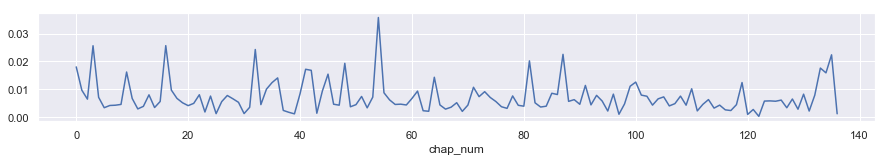

In [38]:
D.tf.plot(figsize=(15,2))

## Get all doc pairs

In [39]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [40]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [41]:
P.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

## Compute Euclidean distance

In [42]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [43]:
P['euclidean'] = 0

In [44]:
P['euclidean'] = P.apply(euclidean, 1)

In [45]:
PME = P.euclidean.unstack().fillna(0)

In [46]:
PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.174179,0.205737,0.156459,0.197897,0.242148,0.255097,0.230901,0.251028,0.208663,0.190091,...,0.254874,0.181217,0.273255,0.170700,0.248984,0.181002,0.145870,0.145798,0.141013,0.347628
1,0.000000,0.217560,0.172748,0.209998,0.251201,0.263195,0.243515,0.260404,0.223955,0.201891,...,0.268044,0.196612,0.285162,0.185443,0.261658,0.196576,0.166898,0.164915,0.161102,0.354813
2,0.000000,0.000000,0.197813,0.231557,0.274446,0.274800,0.263181,0.279130,0.247545,0.227961,...,0.285633,0.225730,0.301587,0.216332,0.281493,0.224347,0.198565,0.197765,0.192821,0.370314
3,0.000000,0.000000,0.000000,0.180867,0.228593,0.253178,0.230168,0.246647,0.205757,0.179513,...,0.254312,0.179021,0.271403,0.168020,0.248755,0.178861,0.146103,0.145540,0.139880,0.345891
4,0.000000,0.000000,0.000000,0.000000,0.261861,0.279144,0.259408,0.274901,0.240074,0.213057,...,0.282908,0.216698,0.298266,0.203713,0.276329,0.214482,0.188408,0.188016,0.183048,0.366265


## Compute Cosine similarity

In [53]:
# normalizes distance between documents unlike eucledian which is just the distance
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [54]:
P['cosine'] = P.apply(cosine, 1)

In [55]:
PMC = P.cosine.unstack().fillna(0)

In [56]:
PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000345,0.000319,0.000285,0.000198,0.000222,0.000395,0.000371,0.000238,0.000448,0.000270,...,0.000493,0.000374,0.000395,0.000296,0.000393,0.000392,0.000387,0.000372,0.000365,0.000221
1,0.000000,0.000448,0.000359,0.000335,0.000434,0.000638,0.000354,0.000397,0.000338,0.000459,...,0.000334,0.000381,0.000263,0.000394,0.000289,0.000389,0.000273,0.000360,0.000330,0.000343
2,0.000000,0.000000,0.000750,0.000686,0.000372,0.001453,0.000628,0.000659,0.000441,0.000555,...,0.000664,0.000300,0.000631,0.000296,0.000465,0.000409,0.000312,0.000343,0.000427,0.000432
3,0.000000,0.000000,0.000000,0.001130,0.001161,0.000483,0.000363,0.000509,0.000575,0.000822,...,0.000481,0.000440,0.000500,0.000377,0.000344,0.000453,0.000312,0.000319,0.000350,0.000341
4,0.000000,0.000000,0.000000,0.000000,0.000806,0.000521,0.000330,0.000409,0.000391,0.000964,...,0.000277,0.000302,0.000293,0.000514,0.000278,0.000466,0.000303,0.000308,0.000376,0.000277


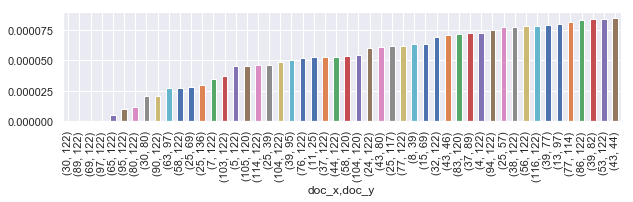

In [57]:
P.cosine.sort_values().head(50).plot(kind='bar', figsize=(10,2 ))

In [58]:
P.cosine.reset_index().to_csv('moby-chapter-pairs.csv', index=False)

## Compare Euclidean and Cosine metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


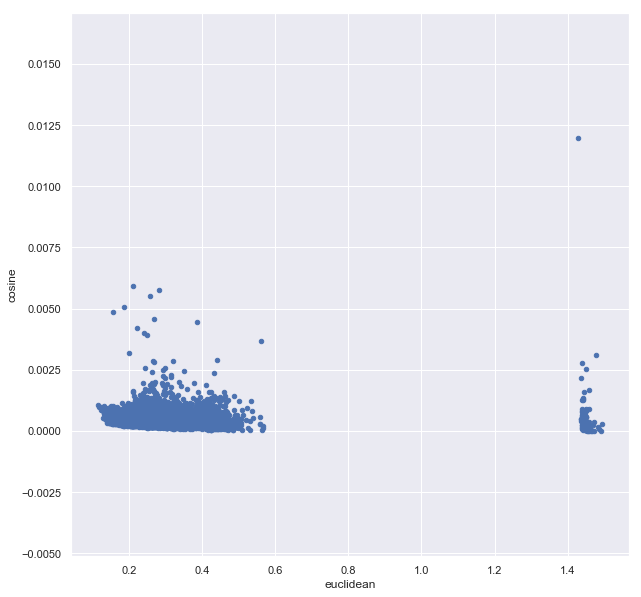

In [59]:
P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10))

In [60]:
P[P.euclidean > .8]

,,euclidean,cosine
doc_x,doc_y,,
0,122,1.438838,0.000373
1,122,1.441334,0.000175
2,122,1.444511,0.000572
3,122,1.438089,0.000642
4,122,1.444279,0.000073
5,122,1.451116,0.000046
6,122,1.452988,0.000377
7,122,1.449686,0.000034
8,122,1.452520,0.000110


## See most similar chapters

In [61]:
P.cosine.sort_values(ascending=False)

doc_x  doc_y
122    127      1.196902e-02
18     22       5.938713e-03
125    129      5.756085e-03
9      83       5.517617e-03
16     18       5.061484e-03
       22       4.859127e-03
93     129      4.593746e-03
43     78       4.470205e-03
20     22       4.224461e-03
93     125      4.013961e-03
18     20       3.916646e-03
25     97       3.680223e-03
16     20       3.174894e-03
120    122      3.118933e-03
       129      2.878948e-03
127    129      2.854199e-03
108    127      2.852526e-03
112    113      2.828237e-03
108    122      2.788526e-03
125    127      2.588587e-03
19     21       2.559818e-03
121    122      2.527912e-03
15     17       2.501481e-03
31     121      2.433588e-03
126    127      2.417034e-03
120    127      2.388129e-03
80     103      2.276453e-03
40     129      2.250157e-03
89     90       2.188486e-03
119    122      2.167672e-03
                    ...     
25     117      6.201933e-05
43     80       6.103857e-05
24     122      6.038618e-05
1

# Compare Significant Words 

We look at distributions of words over chapters. Note, we are not comparing word vectors per se -- we are looking at sequences of words, which has not been discussed in the literature. 

In [62]:
import matplotlib.pyplot as plt

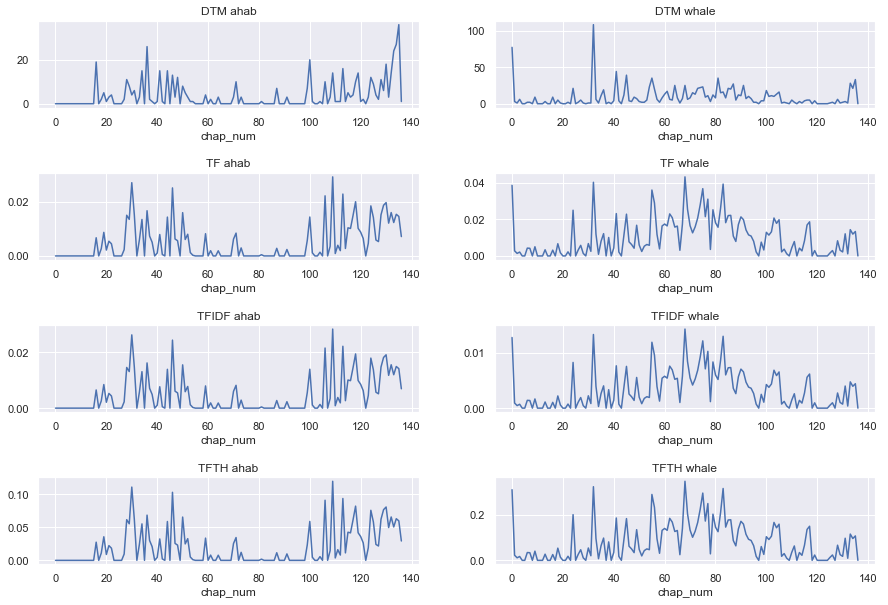

In [63]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('ahab whale'.split()):
    W = get_term_id(V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w)) # document term matrix
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)